#Demo de Alpha Zero para aprender a jugar al Ta-Te-Ti

Basado en https://github.com/suragnair/alpha-zero-general

Explicación en https://pathtopioneer.com/blog/2020/07/rl-6




In [ ]:
#@title Cargar Librerías

import argparse
import os
import shutil
import time
import random
import numpy as np
import math
from matplotlib import pyplot as plt

from collections import deque
from pickle import Pickler, Unpickler
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model

print("Librerías cargadas.")

Librerías cargadas.


## Clases sobre el Problema a resolver

In [ ]:
#@title Definir Juego Ta-Te-Ti

# define el tablero del juego 
class Board():

    # list of all 8 directions on the board, as (x,y) offsets
    __directions = [(1,1),(1,0),(1,-1),(0,-1),(-1,-1),(-1,0),(-1,1),(0,1)]

    def __init__(self, n=3):
        "Set up initial board configuration."

        self.n = n
        # Create the empty board array.
        self.pieces = [None]*self.n
        for i in range(self.n):
            self.pieces[i] = [0]*self.n

    # add [][] indexer syntax to the Board
    def __getitem__(self, index): 
        return self.pieces[index]

    def get_legal_moves(self, color):
        """Returns all the legal moves for the given color.
        (1 for white, -1 for black)
        @param color not used and came from previous version.        
        """
        moves = set()  # stores the legal moves.

        # Get all the empty squares (color==0)
        for y in range(self.n):
            for x in range(self.n):
                if self[x][y]==0:
                    newmove = (x,y)
                    moves.add(newmove)
        return list(moves)

    def has_legal_moves(self):
        for y in range(self.n):
            for x in range(self.n):
                if self[x][y]==0:
                    return True
        return False
    
    def is_win(self, color):
        """Check whether the given player has collected a triplet in any direction; 
        @param color (1=white,-1=black)
        """
        win = self.n
        # check y-strips
        for y in range(self.n):
            count = 0
            for x in range(self.n):
                if self[x][y]==color:
                    count += 1
            if count==win:
                return True
        # check x-strips
        for x in range(self.n):
            count = 0
            for y in range(self.n):
                if self[x][y]==color:
                    count += 1
            if count==win:
                return True
        # check two diagonal strips
        count = 0
        for d in range(self.n):
            if self[d][d]==color:
                count += 1
        if count==win:
            return True
        count = 0
        for d in range(self.n):
            if self[d][self.n-d-1]==color:
                count += 1
        if count==win:
            return True
        
        return False

    def execute_move(self, move, color):
        """Perform the given move on the board; 
        color gives the color pf the piece to play (1=white,-1=black)
        """

        (x,y) = move

        # Add the piece to the empty square.
        assert self[x][y] == 0
        self[x][y] = color

# define el juego a aprender
class ProblemGame:
    def __init__(self, n=3):
        self.n = n

    def getInitBoard(self):
        # return initial board (numpy board)
        b = Board(self.n)
        return np.array(b.pieces)

    def getBoardSize(self):
        # (a,b) tuple
        return (self.n, self.n)

    def getActionSize(self):
        # return number of actions
        return self.n*self.n + 1

    def getNextState(self, board, player, action):
        # if player takes action on board, return next (board,player)
        # action must be a valid move
        if action == self.n*self.n:
            return (board, -player)
        b = Board(self.n)
        b.pieces = np.copy(board)
        move = (int(action/self.n), action%self.n)
        b.execute_move(move, player)
        return (b.pieces, -player)

    def getValidMoves(self, board, player):
        # return a fixed size binary vector
        valids = [0]*self.getActionSize()
        b = Board(self.n)
        b.pieces = np.copy(board)
        legalMoves =  b.get_legal_moves(player)
        if len(legalMoves)==0:
            valids[-1]=1
            return np.array(valids)
        for x, y in legalMoves:
            valids[self.n*x+y]=1
        return np.array(valids)

    def getGameEnded(self, board, player):
        # return 0 if not ended, 1 if player 1 won, -1 if player 1 lost
        # player = 1
        b = Board(self.n)
        b.pieces = np.copy(board)

        if b.is_win(player):
            return 1
        if b.is_win(-player):
            return -1
        if b.has_legal_moves():
            return 0
        # draw has a very little value 
        return 1e-4

    def getCanonicalForm(self, board, player):
        # return state if player==1, else return -state if player==-1
        return player*board

    def getSymmetries(self, board, pi):
        # Si el tablero del juego es simétrico
        # este método permite rotarlo (mirror, rotational)
        # para generar más ejemplos
        # asociado a las mismas probabilidades (genera más ejemplos para aprender)
        assert(len(pi) == self.n**2+1)  # 1 for pass
        pi_board = np.reshape(pi[:-1], (self.n, self.n))
        l = []

        for i in range(1, 5):
            for j in [True, False]:
                newB = np.rot90(board, i)
                newPi = np.rot90(pi_board, i)
                if j:
                    newB = np.fliplr(newB)
                    newPi = np.fliplr(newPi)
                l += [(newB, list(newPi.ravel()) + [pi[-1]])]
        return l

    def stringRepresentation(self, board):
        # 8x8 numpy array (canonical board)
        return board.tostring()

    @staticmethod
    def display(board):
        n = board.shape[0]
        sangria = "     "
        print(sangria, "   ", end="")
        for y in range(n):
            print(y, "", end="")
        print("")
        print(sangria, "  ", end="")
        for _ in range(n):
            print("-", end="-")
        print("--")
        for y in range(n):
            print(sangria, y, "|",end="")    # print the row #
            for x in range(n):
                piece = board[y][x]    # get the piece to print
                if piece == -1: print("X ",end="")
                elif piece == 1: print("O ",end="")
                else:
                    if x==n:
                        print("-",end="")
                    else:
                        print("- ",end="")
            print("|")

        print(sangria, "  ", end="")
        for _ in range(n):
            print("-", end="-")
        print("--")

# define jugador que juega al azar  
class RandomPlayer():
    def __init__(self, game):
        self.game = game

    def play(self, board):
        a = np.random.randint(self.game.getActionSize())
        valids = self.game.getValidMoves(board, 1)
        while valids[a]!=1:
            a = np.random.randint(self.game.getActionSize())
        return a


# define jugador humano para jugar 
class HumanPlayer():
   
    def __init__(self, game):
        self.game = game

    def play(self, board):
        # display(board)
        valid = self.game.getValidMoves(board, 1)
        while True: 
            print("Indique la coordenada donde desea jugar: ")
            a = input()
            x, y = -1, -1
            if a.find(' ') > 0:
              x, y = [int(x) for x in a.split(' ')]
            else:
              if a[0].isnumeric() and a[1].isnumeric():
                x = int(a[0])
                y = int(a[1])
            a = self.game.n * x + y if x!= -1 else self.game.n ** 2
            if (a>=0) and (a<len(valid)) and valid[a]:
                break
            else:
                print('Coordenada inválida')

        return a

print("Clases del Juego definidas")

Clases del Juego definidas


In [ ]:
#@title Definir clase de Arena para hacer las competencias

class Arena():
    """
    An Arena class where any 2 agents can be pit against each other.
    """

    def __init__(self, player1, player2, game, display=None, descJug1="Jugador 1", descJug2="Jugador 2"):
        """
        Input:
            player 1,2: two functions that takes board as input, return action
            game: Game object
            display: a function that takes board as input and prints it. Is necessary for verbose
                     mode.
        """
        self.player1 = player1
        self.player2 = player2
        self.descP1 = descJug1
        self.descP2 = descJug2
        self.game = game
        self.display = display

    def devolverDescPlayer(self, id):
      if id == 1:
        return self.descP1
      elif id == -1:
        return self.descP2
      else:
        return "Jugador-"+str(id)

    def devolverResultadoGame(self, board):
        res = self.game.getGameEnded(board, 1)
        resStr = "* Game Over:"        
        if res == 1:
            resStr = resStr + " ---> Ganó " + self.descP1 + " contra " + self.descP2 + " "
        elif res == -1:
            resStr = resStr + " ---> Ganó " + self.descP2 + " contra " + self.descP1 + " "
        else:
            resStr = resStr + " ---> Empataron " + self.descP1 + " y " + self.descP2 + " "
        return resStr

    def playGame(self, verbose=False, ordenAzar=False):
        """
        Executes one episode of a game.
        Returns:
            either
                winner: player who won the game (1 if player1, -1 if player2)
            or
                draw result returned from the game that is neither 1, -1, nor 0.
        """
        if ordenAzar:
          # determina quien comienza
          if random.randint(1,2)==2:
            # si sale el 2do, invierte orden
            self.player1, self.player2 = self.player2, self.player1
            self.descP1, self.descP2 = self.descP2, self.descP1

        players = [self.player2, None, self.player1]        
        curPlayer = 1
        board = self.game.getInitBoard()
        it = 0
        while self.game.getGameEnded(board, curPlayer) == 0:
            it += 1
            if verbose:
                if it == 1:
                  print("  " + str(it) + ") comienza " + self.devolverDescPlayer(curPlayer))
                else:
                  print("  " +str(it) + ") le toca a " + self.devolverDescPlayer(curPlayer))
            # determina la acción aplicada
            action = players[curPlayer + 1](self.game.getCanonicalForm(board, curPlayer))
            valids = self.game.getValidMoves(self.game.getCanonicalForm(board, curPlayer), 1)
            if valids[action] == 0:
                # si es acción no válida
                print(' Acción {action} not válida!')
                print(' (las válidas son = {valids})')
                assert valids[action] > 0
            else:
                # aplica la acción
                board, curPlayer = self.game.getNextState(board, curPlayer, action)            
                if verbose:
                    assert self.display
                    self.display(board)
        if verbose:
            print("  " +self.devolverResultadoGame(board)+"\n")
        return curPlayer * self.game.getGameEnded(board, curPlayer)

    def playGames(self, numTotal, verbose=False):
        """
        Plays num games in which player1 starts num/2 games and player2 starts
        num/2 games.
        Returns:
            oneWon: games won by player1
            twoWon: games won by player2
            draws:  games won by nobody
        """

        num = int(numTotal / 2)
        if num == 0:
          num = 1
          
        oneWon = 0
        twoWon = 0
        draws = 0
        for _ in tqdm(range(num), desc="Arena.playGames (comienza "+self.descP1+")"):
            gameResult = self.playGame(verbose=verbose)
            if gameResult == 1:
                oneWon += 1
            elif gameResult == -1:
                twoWon += 1
            else:
                draws += 1

        # invierte los jugadores
        self.player1, self.player2 = self.player2, self.player1
        self.descP1, self.descP2 = self.descP2, self.descP1

        for _ in tqdm(range(num), desc="Arena.playGames (comienza "+self.descP1+")"):
            gameResult = self.playGame(verbose=verbose)
            if gameResult == -1:
                oneWon += 1
            elif gameResult == 1:
                twoWon += 1
            else:
                draws += 1

        return oneWon, twoWon, draws


print("Clase Arena definida")    


# inicializa el juego
juego = ProblemGame()

# inicializa jugadores
jugRND = RandomPlayer(juego).play
jugHMN = HumanPlayer(juego).play

# Probar el entorno definido con Política Aleatoria (opcional)
Probar_Juego_Automatico = True #@param {type:"boolean"}

if Probar_Juego_Automatico:
  print("\n> Probando el entorno del problema usando jungadores al azar:")
  Arena(jugRND, jugRND, juego, display=ProblemGame.display, descJug1="Azar_1", descJug2="Azar_2").playGame(verbose=True)

Probar_Juego_Usuario = False #@param {type:"boolean"}

if Probar_Juego_Usuario:
  print("\n> Probando el entorno del problema usando Azar y Usuario (humano):")
  # define usuario humano
  Arena(jugRND, jugHMN, juego, display=ProblemGame.display, descJug1="Azar", descJug2="Usuario").playGame(verbose=True, ordenAzar=True)
  

Clase Arena definida

> Probando el entorno del problema usando jungadores al azar:
  1) comienza Azar_1
         0 1 2 
        --------
      0 |- - - |
      1 |O - - |
      2 |- - - |
        --------
  2) le toca a Azar_2
         0 1 2 
        --------
      0 |- X - |
      1 |O - - |
      2 |- - - |
        --------
  3) le toca a Azar_1
         0 1 2 
        --------
      0 |O X - |
      1 |O - - |
      2 |- - - |
        --------
  4) le toca a Azar_2
         0 1 2 
        --------
      0 |O X - |
      1 |O X - |
      2 |- - - |
        --------
  5) le toca a Azar_1
         0 1 2 
        --------
      0 |O X - |
      1 |O X O |
      2 |- - - |
        --------
  6) le toca a Azar_2
         0 1 2 
        --------
      0 |O X - |
      1 |O X O |
      2 |- X - |
        --------
  * Game Over: ---> Ganó Azar_2 contra Azar_1 



##Clases para AlphaZero

In [ ]:
#@title Definir clases para RNA del Agente

class NNet():
    def __init__(self, game, args):
        # game params
        self.board_x, self.board_y = game.getBoardSize()
        self.action_size = game.getActionSize()
        self.args = args

        if self.args is None:
           self.model = None
        else:
          # Neural Net
          # AlphaZero uses a deep neural network (pi,v)=f(s)
          # which takes the board position "s" as an input 
          # and outputs a vector of move probabilities "p=Pr(a|s)" for each action "a",
          # and a scalar value "v" estiamting the expected outcome "z" from position "s",        
          # Here it learns these move probabilities and value estimates entirely from self-play, 
          # which are then used guide its search.
          self.input_boards = Input(shape=(self.board_x, self.board_y))    # s: batch_size x board_x x board_y

          x_image = Reshape((self.board_x, self.board_y, 1))(self.input_boards)                # batch_size  x board_x x board_y x 1
          h_conv1 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 3, padding='same')(x_image)))         # batch_size  x board_x x board_y x num_channels
          h_conv2 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 3, padding='same')(h_conv1)))         # batch_size  x board_x x board_y x num_channels
          h_conv3 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 3, padding='same')(h_conv2)))        # batch_size  x (board_x) x (board_y) x num_channels
          h_conv4 = Activation('relu')(BatchNormalization(axis=3)(Conv2D(args.num_channels, 3, padding='valid')(h_conv3)))        # batch_size  x (board_x-2) x (board_y-2) x num_channels
          h_conv4_flat = Flatten()(h_conv4)       
          s_fc1 = Dropout(args.dropout)(Activation('relu')(BatchNormalization(axis=1)(Dense(1024)(h_conv4_flat))))  # batch_size x 1024
          s_fc2 = Dropout(args.dropout)(Activation('relu')(BatchNormalization(axis=1)(Dense(512)(s_fc1))))          # batch_size x 1024
          # "pi" is the MCTS informed policy vector for the given board,         
          self.pi = Dense(self.action_size, activation='softmax', name='pi')(s_fc2)   # batch_size x self.action_size
          # "v" is its value. 
          self.v = Dense(1, activation='tanh', name='v')(s_fc2)                    # batch_size x 1

          self.model = Model(inputs=self.input_boards, outputs=[self.pi, self.v])
          self.model.compile(loss=['categorical_crossentropy','mean_squared_error'], optimizer=Adam(args.lr))
          # muestra el modelo creado
          self.model.summary()


class NNetWrapper():
    def __init__(self, game, args):
        self.nnet = NNet(game, args)
        self.board_x, self.board_y = game.getBoardSize()
        self.action_size = game.getActionSize()
        self.trainHistory = []

    def train(self, examples):
       # nota se hace una pequeña modificación para guardar información para generar gráfico
        """
        examples: list of examples, each example is of form (board, pi, v)
        """
        input_boards, target_pis, target_vs = list(zip(*examples))
        input_boards = np.asarray(input_boards)
        target_pis = np.asarray(target_pis)
        target_vs = np.asarray(target_vs)
        # entrena y guada histórico para el gráfico
        history = self.nnet.model.fit(x = input_boards, y = [target_pis, target_vs], batch_size = args.batch_size, epochs = args.epochs)
        self.trainHistory.append( history )

    def genTrainGraphs(self, infoGraficar='loss', titulo="Gráfico del Entrenamiento"):
      # nota se agrega este método para gráficar resultados del entrenamiento
      plt.figure(figsize=(15,8))       
      legs = []
      for i in range(len(self.trainHistory)):
        plt.plot(self.trainHistory[i].history[infoGraficar])
        legs.append( "Iter "+str(i+1))
      plt.title(titulo)
      plt.legend(legs, loc='best')
      plt.ylabel('')
      plt.xlabel('Epoch')
      plt.show()


    def predict(self, board):
        """
        board: np array with board
        Returns:
            pi: a policy vector for the current board- a numpy array of length
                game.getActionSize
            v: a float in [-1,1] that gives the value of the current board
        """
        # timing
        ##start = time.time()

        # preparing input
        board = board[np.newaxis, :, :]

        # run
        pi, v = self.nnet.model.predict(board, verbose=0)

        ##print('PREDICTION TIME TAKEN : {0:03f}'.format(time.time()-start))
        ##print("PI ", pi, "--", v)
        return pi[0], v[0]
    
    def save_checkpoint(self, folder='checkpoint', filename='checkpoint.h5'):
      # nota se hace una pequeña modificación para que funcione corretamente
        filepath = os.path.join(folder, filename)
        if not os.path.exists(folder):
            print("  No existe el directorio de checkpoints! Se crea {}".format(folder))
            os.mkdir(folder)
        #else:
        #    print("Checkpoint Directory exists! ")
        self.nnet.model.save_weights(filepath)
        print("  Checkpoint grabado en '{}'".format(filepath))

    def load_checkpoint(self, folder='checkpoint', filename='checkpoint.h5'):
      # nota se hace una pequeña modificación para que funcione corretamente
        filepath = os.path.join(folder, filename)          
        if not os.path.exists(folder):
          print("  No se encuentra un checkpoint en '{}'".format(filepath))
          #  raise("No model in path '{}'".format(filepath))
        else:
          self.nnet.model.load_weights(filepath)
          print("  Checkpoint cargado de '{}'".format(filepath))


    def save_model(self, folder='model', filename='model.h5'):
      # nota nuevo método para guardar todo el modelo
        filepath = os.path.join(folder, filename)
        if not os.path.exists(folder):
            print("  No existe el directorio para guardar el modelo! Se crea {}".format(folder))
            os.mkdir(folder)
        #else:
        #    print("Checkpoint Directory exists! ")
        self.nnet.model.save(filepath)
        print("  Checkpoint grabado en '{}'".format(filepath))

    def load_model(self, folder='model', filename='model.h5'):
      # nota nuevo método para cargar todo el modelo
        filepath = os.path.join(folder, filename)          
        if not os.path.exists(folder):
          print("  No se encuentra el modelo guardado en '{}'".format(filepath))
          #  raise("No model in path '{}'".format(filepath))
        else:
          self.nnet.model = load_model(filepath)
          print("  Modelo cargado de '{}'".format(filepath))
          # muestra el modelo creado
          self.nnet.model.summary()          


print("Clases de la RNA definidas.")

Clases de la RNA definidas.


In [ ]:
#@title Definir clase Monte Carlo tree search (MCTS)

# we don’t directly train our policy network to make “good” moves.
# Instead we train it to mimic the output of the Monte Carlo Tree Search.
# As we play games, the policy network suggests moves to MCTS.
# MCTS uses these suggestions (or priors) to explore the game tree 
# and returns a better set of probabilities for a given state. 
# We record the state and the probabilities produced by the MCTS.
# --> Despite the world’s focus on the neural networks involved in AlphaZero,
#  the true magic of AlphaZero actually comes from Monte Carlo Tree Search. 
# It’s here that AlphaZero simulates moves 
# and looks ahead to explore a range of promising moves.

EPS = 1e-8

class MCTS():
    """
    This class handles the MCTS tree.
    """

    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
        self.args = args
        self.Qsa = {}  # stores Q values for s,a (as defined in the paper)
        self.Nsa = {}  # stores #times edge s,a was visited
        self.Ns = {}  # stores #times board s was visited
        self.Ps = {}  # stores initial policy (returned by neural net)

        self.Es = {}  # stores game.getGameEnded ended for board s
        self.Vs = {}  # stores game.getValidMoves for board s

    def getActionProb(self, canonicalBoard, temp=1):
        """
        This function performs numMCTSSims simulations of MCTS starting from
        canonicalBoard.
        Returns:
            probs: a policy vector where the probability of the ith action is
                   proportional to Nsa[(s,a)]**(1./temp)
        """
        for i in range(self.args.numMCTSSims):
            self.search(canonicalBoard)

        s = self.game.stringRepresentation(canonicalBoard)
        counts = [self.Nsa[(s, a)] if (s, a) in self.Nsa else 0 for a in range(self.game.getActionSize())]

        if temp == 0:
            bestAs = np.array(np.argwhere(counts == np.max(counts))).flatten()
            bestA = np.random.choice(bestAs)
            probs = [0] * len(counts)
            probs[bestA] = 1
            return probs

        counts = [x ** (1. / temp) for x in counts]
        counts_sum = float(sum(counts))
        probs = [x / counts_sum for x in counts]
        return probs

    def search(self, canonicalBoard):
        """
        This function performs one iteration of MCTS. It is recursively called
        till a leaf node is found. The action chosen at each node is one that
        has the maximum upper confidence bound as in the paper.
        Once a leaf node is found, the neural network is called to return an
        initial policy P and a value v for the state. This value is propagated
        up the search path. In case the leaf node is a terminal state, the
        outcome is propagated up the search path. The values of Ns, Nsa, Qsa are
        updated.
        NOTE: the return values are the negative of the value of the current
        state. This is done since v is in [-1,1] and if v is the value of a
        state for the current player, then its value is -v for the other player.
        Returns:
            v: the negative of the value of the current canonicalBoard
        """

        s = self.game.stringRepresentation(canonicalBoard)

        if s not in self.Es:
            self.Es[s] = self.game.getGameEnded(canonicalBoard, 1)
        if self.Es[s] != 0:
            # terminal node
            return -self.Es[s]

        if s not in self.Ps:
            # leaf node
            self.Ps[s], v = self.nnet.predict(canonicalBoard)
            valids = self.game.getValidMoves(canonicalBoard, 1)
            self.Ps[s] = self.Ps[s] * valids  # masking invalid moves
            sum_Ps_s = np.sum(self.Ps[s])
            if sum_Ps_s > 0:
                self.Ps[s] /= sum_Ps_s  # renormalize
            else:
                # if all valid moves were masked make all valid moves equally probable

                # NB! All valid moves may be masked if either your NNet architecture is insufficient or you've get overfitting or something else.
                # If you have got dozens or hundreds of these messages you should pay attention to your NNet and/or training process.   
                print("All valid moves were masked, doing a workaround.")
                self.Ps[s] = self.Ps[s] + valids
                self.Ps[s] /= np.sum(self.Ps[s])

            self.Vs[s] = valids
            self.Ns[s] = 0
            return -v

        valids = self.Vs[s]
        cur_best = -float('inf')
        best_act = -1

        # pick the action with the highest upper confidence bound
        for a in range(self.game.getActionSize()):
            if valids[a]:
                if (s, a) in self.Qsa:
                    u = self.Qsa[(s, a)] + self.args.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s]) / (
                            1 + self.Nsa[(s, a)])
                else:
                    u = self.args.cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s] + EPS)  # Q = 0 ?

                if u > cur_best:
                    cur_best = u
                    best_act = a

        a = best_act
        next_s, next_player = self.game.getNextState(canonicalBoard, 1, a)
        next_s = self.game.getCanonicalForm(next_s, next_player)

        v = self.search(next_s)

        if (s, a) in self.Qsa:
            self.Qsa[(s, a)] = (self.Nsa[(s, a)] * self.Qsa[(s, a)] + v) / (self.Nsa[(s, a)] + 1)
            self.Nsa[(s, a)] += 1

        else:
            self.Qsa[(s, a)] = v
            self.Nsa[(s, a)] = 1

        self.Ns[s] += 1
        return -v


class dotdict(dict):
    def __getattr__(self, name):
        return self[name]


# define método para crear jugador AlphaZero
def AlphaZeroPlayer(game, nnet):
        mctsArgs = dotdict({'numMCTSSims': 50, 'cpuct': 1.0})
        mctsNN = MCTS(game, nnet, mctsArgs)
        return lambda x: np.argmax(mctsNN.getActionProb(x, temp=0))

print("Clase MCTS definida")


Clase MCTS definida


In [ ]:
#@title Definir clase Coach

class Coach():
    """
    This class executes the self-play + learning. It uses the functions defined
    in Game and NeuralNet. args are specified in main.py.
    """

    def __init__(self, game, nnet, args):
        self.game = game
        self.nnet = nnet
        self.args = args
        self.pnet = self.nnet.__class__(self.game, self.args)  # the competitor network        
        self.mcts = MCTS(self.game, self.nnet, self.args)
        self.trainExamplesHistory = []  # history of examples from args.numItersForTrainExamplesHistory latest iterations
        self.skipFirstSelfPlay = False  # can be overriden in loadTrainExamples()

    def executeEpisode(self):
        """
        This function executes one episode of self-play, starting with player 1.
        As the game is played, each turn is added as a training example to
        trainExamples. The game is played till the game ends. After the game
        ends, the outcome of the game is used to assign values to each example
        in trainExamples.
        It uses a temp=1 if episodeStep < tempThreshold, and thereafter
        uses temp=0.
        Returns:
            trainExamples: a list of examples of the form (canonicalBoard, currPlayer, pi,v)
                           pi is the MCTS informed policy vector, v is +1 if
                           the player eventually won the game, else -1.
        """
        trainExamples = []
        board = self.game.getInitBoard()
        self.curPlayer = 1
        episodeStep = 0

        while True:
            episodeStep += 1
            canonicalBoard = self.game.getCanonicalForm(board, self.curPlayer)
            temp = int(episodeStep < self.args.tempThreshold)

            pi = self.mcts.getActionProb(canonicalBoard, temp=temp)
            sym = self.game.getSymmetries(canonicalBoard, pi)
            for b, p in sym:
                trainExamples.append([b, self.curPlayer, p, None])

            action = np.random.choice(len(pi), p=pi)
            board, self.curPlayer = self.game.getNextState(board, self.curPlayer, action)

            r = self.game.getGameEnded(board, self.curPlayer)

            if r != 0:
                return [(x[0], x[2], r * ((-1) ** (x[1] != self.curPlayer))) for x in trainExamples]

    def learn(self):
        """
        Performs numIters iterations with numEps episodes of self-play in each
        iteration. After every iteration, it retrains neural network with
        examples in trainExamples (which has a maximum length of maxlenofQueue).
        It then pits the new neural network against the old one and accepts it
        only if it wins >= updateThreshold fraction of games.
        """
        iterRes = []
        print("\n** Comienza el Entrenamiento **")
        start = time.time()

        for i in range(1, self.args.numIters + 1):
            # bookkeeping
            print("\n\n ++ Comenzando Iteración de Entrenamiento #{} ++".format(i))
            # examples of the iteration
            if not self.skipFirstSelfPlay or i > 1:
                iterationTrainExamples = deque([], maxlen=self.args.maxlenOfQueue)

                for _ in tqdm(range(self.args.numEps), desc="   Self Play"):
                    self.mcts = MCTS(self.game, self.nnet, self.args)  # reset search tree
                    iterationTrainExamples += self.executeEpisode()

                # save the iteration examples to the history 
                self.trainExamplesHistory.append(iterationTrainExamples)

            if len(self.trainExamplesHistory) > self.args.numItersForTrainExamplesHistory:
                print("   Removiendo el ejemplo más viejo de  trainExamples. len(trainExamplesHistory) = {len(self.trainExamplesHistory)}")
                self.trainExamplesHistory.pop(0)
            # backup history to a file
            # NB! the examples were collected using the model from the previous iteration, so (i-1)  
            self.saveTrainExamples(i - 1)

            # shuffle examples before training
            trainExamples = []
            for e in self.trainExamplesHistory:
                trainExamples.extend(e)
            random.shuffle(trainExamples)

            # training new network, keeping a copy of the old one
            self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
            self.pnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
            pmcts = MCTS(self.game, self.pnet, self.args)

            self.nnet.train(trainExamples)
            nmcts = MCTS(self.game, self.nnet, self.args)

            print('\nCompitiendo contra la versión anterior:')
            arena = Arena(lambda x: np.argmax(pmcts.getActionProb(x, temp=0)),
                          lambda x: np.argmax(nmcts.getActionProb(x, temp=0)), self.game, None, descJug1="Anterior", descJug2="Nuevo")
            pwins, nwins, draws = arena.playGames(self.args.arenaCompare)
            resComp = 'Ganados: %d Nuevo Modelo vs %d Modelo Anterior // Empatados : %d ' % (nwins, pwins, draws)
            print('\n     ' + resComp)
            if pwins + nwins == 0 or float(nwins) / (pwins + nwins) < self.args.updateThreshold:
                resComp = resComp + ' --> RECHAZADO.'
                print('          --> Se RECHAZA el Nuevo Modelo\n')
                self.nnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
            else:
                resComp = resComp + ' --> ACEPTADO.'
                print('          --> Se ACEPTA el Nuevo Modelo\n')
                self.nnet.save_checkpoint(folder=self.args.checkpoint, filename=self.getCheckpointFile(i))
                self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='best.pth.tar')            
            iterRes.append( resComp )

        print('\n** Entrenamiento finalizado **')
        print('    - Duración: {0:03f} minutos '.format((time.time()-start)/60))
        print('    - Resumen de Modelos generados: ')
        for i in range(len(iterRes)):
          print('       ' + str(i+1) + ') ' + iterRes[i])
        print("\n")
 

    def getCheckpointFile(self, iteration):
        return 'checkpoint_' + str(iteration) + '.pth.tar'

    def saveTrainExamples(self, iteration):
        folder = self.args.checkpoint
        if not os.path.exists(folder):
            os.makedirs(folder)
        filename = os.path.join(folder, self.getCheckpointFile(iteration) + ".examples")
        with open(filename, "wb+") as f:
            Pickler(f).dump(self.trainExamplesHistory)
        f.closed

    def loadTrainExamples(self):
        modelFile = os.path.join(self.args.load_folder_file[0], self.args.load_folder_file[1])
        examplesFile = modelFile + ".examples"
        if not os.path.isfile(examplesFile):
            print('File "{examplesFile}" with trainExamples not found!')
        else:
            print("File with trainExamples found. Loading it...")
            with open(examplesFile, "rb") as f:
                self.trainExamplesHistory = Unpickler(f).load()
            print('Loading done!')

            # examples based on the model were already collected (loaded)
            self.skipFirstSelfPlay = True

print("Clase Coach definida")

Clase Coach definida


##Entrenamiento + Grabar / Cargar Modelo

In [ ]:
#@title Generar Datos y Entrenar 
#@markdown Parámetros sobre el Entrenamiento:
entrenar = True # @param {type:"boolean"}
cantidad_entrenamientos =  10# @param {type:"integer"}
cant_ciclos_por_entrenamiento = 150 # @param {type:"integer"}
cant_jugadas_usar_datos_entrenamiento = 10 # @param {type:"integer"}
cantidad_datos_entrenamiento = 1500 # @param {type:"integer"}
cant_juegos_realizar_comparar_version_anterior = 10 # @param {type:"integer"}


# define los parámetros generales
"""
Performs numIters iterations with numEps episodes of self-play in each
iteration. After every iteration, it retrains neural network with
examples in trainExamples (which has a maximum length of maxlenofQueue).
It then pits the new neural network against the old one and accepts it
only if it wins >= updateThreshold fraction of games.
"""

args = dotdict({
    'numIters': cantidad_entrenamientos,
    'numEps': cant_jugadas_usar_datos_entrenamiento,
    'tempThreshold': 15,        #
    'updateThreshold': 0.6,     # During arena playoff, new neural net will be accepted if threshold or more of games are won.
    'maxlenOfQueue': cantidad_datos_entrenamiento,    
    'numMCTSSims': 25,          # Number of games moves for MCTS to simulate.
    'arenaCompare': cant_juegos_realizar_comparar_version_anterior,         # Number of games to play during arena play to determine if new net will be accepted.
    'cpuct': 1,
    # define parámetros para manejo de guardado del modelo
    'checkpoint': '/content/alpha-zero-general/tictactoe/temp/',
    'load_model': False,
    'load_folder_file': ('/content/alpha-zero-general/tictactoe/pretrained','best.pth.tar.data-00000-of-00001'),
    'numItersForTrainExamplesHistory': 20,
    # define parámetros para RNA
    'lr': 0.01, #0.001,
    'dropout': 0.3,
    'epochs': cant_ciclos_por_entrenamiento,
    'batch_size': 64,
    'cuda': True, # False,
    'num_channels': 512,
})       


if entrenar:

    # define la red a entrenar
    nnet = NNetWrapper(juego, args)

    if args.load_model:
        print('-- Cargando checkpoint inicial "%s/%s"...', args.load_folder_file)
        nnet.load_checkpoint(args.load_folder_file[0], args.load_folder_file[1])

    # carga el asistente para definir datos y entrenar
    c = Coach(juego, nnet, args)

    #  genera los datos (jugando contra sí mismo) 
    # y entrena la Red  haciendola competir con la anterior 
    # para ver si mejora o no
    c.learn()

    # define agente AlphaZero basado en la red entrenada
    jugAZ = AlphaZeroPlayer(juego, nnet)
    
else:
    print("No se ejecuta el entrenamiento.") 


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 3)]       0           []                               
                                                                                                  
 reshape (Reshape)              (None, 3, 3, 1)      0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 3, 3, 512)    5120        ['reshape[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 3, 3, 512)   2048        ['conv2d[0][0]']                 
 alization)                                                                                   

   Self Play:   0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-2-328dd03b9c50>:174: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return board.tostring()
   Self Play: 100%|██████████| 10/10 [01:07<00:00,  6.72s/it]


  Checkpoint grabado en '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'
  Checkpoint cargado de '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'
Epoch 1/150
9/9 [==============================] - 8s 70ms/step - loss: 4.3411 - pi_loss: 2.9667 - v_loss: 1.3744
Epoch 2/150
9/9 [==============================] - 0s 18ms/step - loss: 3.9362 - pi_loss: 2.5336 - v_loss: 1.4026
Epoch 3/150
9/9 [==============================] - 0s 17ms/step - loss: 3.6271 - pi_loss: 2.3571 - v_loss: 1.2700
Epoch 4/150
9/9 [==============================] - 0s 17ms/step - loss: 3.3156 - pi_loss: 2.3619 - v_loss: 0.9537
Epoch 5/150
9/9 [==============================] - 0s 16ms/step - loss: 3.2907 - pi_loss: 2.3938 - v_loss: 0.8969
Epoch 6/150
9/9 [==============================] - 0s 16ms/step - loss: 3.1786 - pi_loss: 2.4395 - v_loss: 0.7391
Epoch 7/150
9/9 [==============================] - 0s 16ms/step - loss: 3.1514 - pi_loss: 2.4324 - v_loss: 0.7189
Epoch 8/150
9/9 [=====================

Arena.playGames (comienza Nuevo): 100%|██████████| 5/5 [00:18<00:00,  3.79s/it]



     Ganados: 7 Nuevo Modelo vs 2 Modelo Anterior // Empatados : 1 
          --> Se ACEPTA el Nuevo Modelo

  Checkpoint grabado en '/content/alpha-zero-general/tictactoe/temp/checkpoint_1.pth.tar'
  Checkpoint grabado en '/content/alpha-zero-general/tictactoe/temp/best.pth.tar'


 ++ Comenzando Iteración de Entrenamiento #2 ++


   Self Play: 100%|██████████| 10/10 [00:40<00:00,  4.09s/it]


  Checkpoint grabado en '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'
  Checkpoint cargado de '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'
Epoch 1/150
18/18 [==============================] - 0s 18ms/step - loss: 1.8891 - pi_loss: 1.5342 - v_loss: 0.3549
Epoch 2/150
18/18 [==============================] - 0s 15ms/step - loss: 1.8526 - pi_loss: 1.5152 - v_loss: 0.3374
Epoch 3/150
18/18 [==============================] - 0s 15ms/step - loss: 1.7619 - pi_loss: 1.4490 - v_loss: 0.3129
Epoch 4/150
18/18 [==============================] - 0s 16ms/step - loss: 1.6955 - pi_loss: 1.4016 - v_loss: 0.2938
Epoch 5/150
18/18 [==============================] - 0s 15ms/step - loss: 1.6488 - pi_loss: 1.3719 - v_loss: 0.2769
Epoch 6/150
18/18 [==============================] - 0s 16ms/step - loss: 1.6089 - pi_loss: 1.3507 - v_loss: 0.2581
Epoch 7/150
18/18 [==============================] - 0s 16ms/step - loss: 1.5892 - pi_loss: 1.3320 - v_loss: 0.2572
Epoch 8/150
18/18 [=====

Arena.playGames (comienza Nuevo): 100%|██████████| 5/5 [00:12<00:00,  2.54s/it]



     Ganados: 5 Nuevo Modelo vs 3 Modelo Anterior // Empatados : 2 
          --> Se ACEPTA el Nuevo Modelo

  Checkpoint grabado en '/content/alpha-zero-general/tictactoe/temp/checkpoint_2.pth.tar'
  Checkpoint grabado en '/content/alpha-zero-general/tictactoe/temp/best.pth.tar'


 ++ Comenzando Iteración de Entrenamiento #3 ++


   Self Play: 100%|██████████| 10/10 [00:32<00:00,  3.23s/it]


  Checkpoint grabado en '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'
  Checkpoint cargado de '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'
Epoch 1/150
26/26 [==============================] - 1s 32ms/step - loss: 1.5416 - pi_loss: 1.3216 - v_loss: 0.2200
Epoch 2/150
26/26 [==============================] - 0s 17ms/step - loss: 1.5347 - pi_loss: 1.3262 - v_loss: 0.2085
Epoch 3/150
26/26 [==============================] - 0s 17ms/step - loss: 1.5365 - pi_loss: 1.3243 - v_loss: 0.2121
Epoch 4/150
26/26 [==============================] - 0s 17ms/step - loss: 1.5229 - pi_loss: 1.3101 - v_loss: 0.2128
Epoch 5/150
26/26 [==============================] - 0s 16ms/step - loss: 1.5250 - pi_loss: 1.3167 - v_loss: 0.2083
Epoch 6/150
26/26 [==============================] - 0s 15ms/step - loss: 1.4993 - pi_loss: 1.2972 - v_loss: 0.2021
Epoch 7/150
26/26 [==============================] - 0s 15ms/step - loss: 1.4964 - pi_loss: 1.2914 - v_loss: 0.2050
Epoch 8/150
26/26 [=====

Arena.playGames (comienza Nuevo): 100%|██████████| 5/5 [00:19<00:00,  3.87s/it]



     Ganados: 1 Nuevo Modelo vs 4 Modelo Anterior // Empatados : 5 
          --> Se RECHAZA el Nuevo Modelo

  Checkpoint cargado de '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'


 ++ Comenzando Iteración de Entrenamiento #4 ++


   Self Play: 100%|██████████| 10/10 [00:33<00:00,  3.39s/it]


  Checkpoint grabado en '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'
  Checkpoint cargado de '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'
Epoch 1/150
34/34 [==============================] - 1s 18ms/step - loss: 1.5595 - pi_loss: 1.3462 - v_loss: 0.2133
Epoch 2/150
34/34 [==============================] - 1s 15ms/step - loss: 1.5465 - pi_loss: 1.3566 - v_loss: 0.1899
Epoch 3/150
34/34 [==============================] - 1s 15ms/step - loss: 1.4968 - pi_loss: 1.3082 - v_loss: 0.1886
Epoch 4/150
34/34 [==============================] - 1s 17ms/step - loss: 1.4583 - pi_loss: 1.2846 - v_loss: 0.1737
Epoch 5/150
34/34 [==============================] - 1s 17ms/step - loss: 1.4727 - pi_loss: 1.2855 - v_loss: 0.1872
Epoch 6/150
34/34 [==============================] - 1s 16ms/step - loss: 1.4595 - pi_loss: 1.2777 - v_loss: 0.1818
Epoch 7/150
34/34 [==============================] - 1s 17ms/step - loss: 1.4551 - pi_loss: 1.2780 - v_loss: 0.1771
Epoch 8/150
34/34 [=====

Arena.playGames (comienza Nuevo): 100%|██████████| 5/5 [00:18<00:00,  3.78s/it]



     Ganados: 3 Nuevo Modelo vs 0 Modelo Anterior // Empatados : 7 
          --> Se ACEPTA el Nuevo Modelo

  Checkpoint grabado en '/content/alpha-zero-general/tictactoe/temp/checkpoint_4.pth.tar'
  Checkpoint grabado en '/content/alpha-zero-general/tictactoe/temp/best.pth.tar'


 ++ Comenzando Iteración de Entrenamiento #5 ++


   Self Play: 100%|██████████| 10/10 [00:44<00:00,  4.43s/it]


  Checkpoint grabado en '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'
  Checkpoint cargado de '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'
Epoch 1/150
45/45 [==============================] - 1s 23ms/step - loss: 1.3217 - pi_loss: 1.1649 - v_loss: 0.1568
Epoch 2/150
45/45 [==============================] - 1s 16ms/step - loss: 1.3269 - pi_loss: 1.1689 - v_loss: 0.1579
Epoch 3/150
45/45 [==============================] - 1s 16ms/step - loss: 1.3566 - pi_loss: 1.1839 - v_loss: 0.1726
Epoch 4/150
45/45 [==============================] - 1s 16ms/step - loss: 1.4410 - pi_loss: 1.2494 - v_loss: 0.1916
Epoch 5/150
45/45 [==============================] - 1s 16ms/step - loss: 1.3931 - pi_loss: 1.2171 - v_loss: 0.1761
Epoch 6/150
45/45 [==============================] - 1s 16ms/step - loss: 1.3699 - pi_loss: 1.1974 - v_loss: 0.1726
Epoch 7/150
45/45 [==============================] - 1s 16ms/step - loss: 1.3462 - pi_loss: 1.1838 - v_loss: 0.1624
Epoch 8/150
45/45 [=====

Arena.playGames (comienza Nuevo): 100%|██████████| 5/5 [00:13<00:00,  2.72s/it]



     Ganados: 0 Nuevo Modelo vs 0 Modelo Anterior // Empatados : 10 
          --> Se RECHAZA el Nuevo Modelo

  Checkpoint cargado de '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'


 ++ Comenzando Iteración de Entrenamiento #6 ++


   Self Play: 100%|██████████| 10/10 [00:43<00:00,  4.32s/it]


  Checkpoint grabado en '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'
  Checkpoint cargado de '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'
Epoch 1/150
54/54 [==============================] - 1s 22ms/step - loss: 1.3689 - pi_loss: 1.1467 - v_loss: 0.2221
Epoch 2/150
54/54 [==============================] - 1s 16ms/step - loss: 1.3841 - pi_loss: 1.1605 - v_loss: 0.2235
Epoch 3/150
54/54 [==============================] - 1s 15ms/step - loss: 1.3467 - pi_loss: 1.1353 - v_loss: 0.2114
Epoch 4/150
54/54 [==============================] - 1s 16ms/step - loss: 1.3341 - pi_loss: 1.1299 - v_loss: 0.2042
Epoch 5/150
54/54 [==============================] - 1s 16ms/step - loss: 1.3425 - pi_loss: 1.1314 - v_loss: 0.2111
Epoch 6/150
54/54 [==============================] - 1s 16ms/step - loss: 1.3317 - pi_loss: 1.1270 - v_loss: 0.2047
Epoch 7/150
54/54 [==============================] - 1s 18ms/step - loss: 1.3177 - pi_loss: 1.1205 - v_loss: 0.1972
Epoch 8/150
54/54 [=====

Arena.playGames (comienza Nuevo): 100%|██████████| 5/5 [00:10<00:00,  2.08s/it]



     Ganados: 0 Nuevo Modelo vs 0 Modelo Anterior // Empatados : 10 
          --> Se RECHAZA el Nuevo Modelo

  Checkpoint cargado de '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'


 ++ Comenzando Iteración de Entrenamiento #7 ++


   Self Play: 100%|██████████| 10/10 [00:45<00:00,  4.50s/it]


  Checkpoint grabado en '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'
  Checkpoint cargado de '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'
Epoch 1/150
63/63 [==============================] - 1s 17ms/step - loss: 1.3960 - pi_loss: 1.1319 - v_loss: 0.2642
Epoch 2/150
63/63 [==============================] - 1s 15ms/step - loss: 1.4034 - pi_loss: 1.1455 - v_loss: 0.2579
Epoch 3/150
63/63 [==============================] - 1s 16ms/step - loss: 1.3612 - pi_loss: 1.1194 - v_loss: 0.2418
Epoch 4/150
63/63 [==============================] - 1s 16ms/step - loss: 1.3633 - pi_loss: 1.1174 - v_loss: 0.2459
Epoch 5/150
63/63 [==============================] - 1s 16ms/step - loss: 1.3291 - pi_loss: 1.1015 - v_loss: 0.2277
Epoch 6/150
63/63 [==============================] - 1s 16ms/step - loss: 1.3303 - pi_loss: 1.0981 - v_loss: 0.2322
Epoch 7/150
63/63 [==============================] - 1s 17ms/step - loss: 1.3208 - pi_loss: 1.0954 - v_loss: 0.2253
Epoch 8/150
63/63 [=====

Arena.playGames (comienza Nuevo): 100%|██████████| 5/5 [00:08<00:00,  1.63s/it]



     Ganados: 0 Nuevo Modelo vs 0 Modelo Anterior // Empatados : 10 
          --> Se RECHAZA el Nuevo Modelo

  Checkpoint cargado de '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'


 ++ Comenzando Iteración de Entrenamiento #8 ++


   Self Play: 100%|██████████| 10/10 [00:39<00:00,  3.94s/it]


  Checkpoint grabado en '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'
  Checkpoint cargado de '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'
Epoch 1/150
71/71 [==============================] - 1s 16ms/step - loss: 1.3603 - pi_loss: 1.1173 - v_loss: 0.2430
Epoch 2/150
71/71 [==============================] - 1s 15ms/step - loss: 1.3676 - pi_loss: 1.1182 - v_loss: 0.2494
Epoch 3/150
71/71 [==============================] - 1s 16ms/step - loss: 1.3389 - pi_loss: 1.0998 - v_loss: 0.2391
Epoch 4/150
71/71 [==============================] - 1s 16ms/step - loss: 1.3146 - pi_loss: 1.0839 - v_loss: 0.2307
Epoch 5/150
71/71 [==============================] - 1s 16ms/step - loss: 1.2901 - pi_loss: 1.0732 - v_loss: 0.2169
Epoch 6/150
71/71 [==============================] - 1s 16ms/step - loss: 1.2925 - pi_loss: 1.0739 - v_loss: 0.2186
Epoch 7/150
71/71 [==============================] - 1s 15ms/step - loss: 1.2902 - pi_loss: 1.0701 - v_loss: 0.2201
Epoch 8/150
71/71 [=====

Arena.playGames (comienza Nuevo): 100%|██████████| 5/5 [00:09<00:00,  1.90s/it]



     Ganados: 0 Nuevo Modelo vs 0 Modelo Anterior // Empatados : 10 
          --> Se RECHAZA el Nuevo Modelo

  Checkpoint cargado de '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'


 ++ Comenzando Iteración de Entrenamiento #9 ++


   Self Play: 100%|██████████| 10/10 [00:40<00:00,  4.05s/it]


  Checkpoint grabado en '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'
  Checkpoint cargado de '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'
Epoch 1/150
81/81 [==============================] - 1s 17ms/step - loss: 1.3361 - pi_loss: 1.0924 - v_loss: 0.2437
Epoch 2/150
81/81 [==============================] - 1s 18ms/step - loss: 1.3041 - pi_loss: 1.0673 - v_loss: 0.2368
Epoch 3/150
81/81 [==============================] - 1s 16ms/step - loss: 1.2751 - pi_loss: 1.0525 - v_loss: 0.2226
Epoch 4/150
81/81 [==============================] - 1s 16ms/step - loss: 1.2657 - pi_loss: 1.0439 - v_loss: 0.2218
Epoch 5/150
81/81 [==============================] - 1s 16ms/step - loss: 1.2496 - pi_loss: 1.0403 - v_loss: 0.2093
Epoch 6/150
81/81 [==============================] - 1s 16ms/step - loss: 1.2532 - pi_loss: 1.0373 - v_loss: 0.2159
Epoch 7/150
81/81 [==============================] - 1s 16ms/step - loss: 1.2449 - pi_loss: 1.0340 - v_loss: 0.2109
Epoch 8/150
81/81 [=====

Arena.playGames (comienza Nuevo): 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]



     Ganados: 0 Nuevo Modelo vs 0 Modelo Anterior // Empatados : 10 
          --> Se RECHAZA el Nuevo Modelo

  Checkpoint cargado de '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'


 ++ Comenzando Iteración de Entrenamiento #10 ++


   Self Play: 100%|██████████| 10/10 [00:41<00:00,  4.13s/it]


  Checkpoint grabado en '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'
  Checkpoint cargado de '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'
Epoch 1/150
90/90 [==============================] - 2s 22ms/step - loss: 1.3134 - pi_loss: 1.0632 - v_loss: 0.2502
Epoch 2/150
90/90 [==============================] - 1s 16ms/step - loss: 1.3007 - pi_loss: 1.0593 - v_loss: 0.2414
Epoch 3/150
90/90 [==============================] - 1s 16ms/step - loss: 1.2739 - pi_loss: 1.0351 - v_loss: 0.2389
Epoch 4/150
90/90 [==============================] - 1s 16ms/step - loss: 1.2528 - pi_loss: 1.0273 - v_loss: 0.2255
Epoch 5/150
90/90 [==============================] - 1s 16ms/step - loss: 1.2380 - pi_loss: 1.0201 - v_loss: 0.2179
Epoch 6/150
90/90 [==============================] - 1s 16ms/step - loss: 1.2335 - pi_loss: 1.0162 - v_loss: 0.2173
Epoch 7/150
90/90 [==============================] - 1s 16ms/step - loss: 1.2281 - pi_loss: 1.0118 - v_loss: 0.2163
Epoch 8/150
90/90 [=====

Arena.playGames (comienza Nuevo): 100%|██████████| 5/5 [00:10<00:00,  2.00s/it]


     Ganados: 0 Nuevo Modelo vs 0 Modelo Anterior // Empatados : 10 
          --> Se RECHAZA el Nuevo Modelo

  Checkpoint cargado de '/content/alpha-zero-general/tictactoe/temp/temp.pth.tar'

** Entrenamiento finalizado **
    - Duración: 34.814773 minutos 
    - Resumen de Modelos generados: 
       1) Ganados: 7 Nuevo Modelo vs 2 Modelo Anterior // Empatados : 1  --> ACEPTADO.
       2) Ganados: 5 Nuevo Modelo vs 3 Modelo Anterior // Empatados : 2  --> ACEPTADO.
       3) Ganados: 1 Nuevo Modelo vs 4 Modelo Anterior // Empatados : 5  --> RECHAZADO.
       4) Ganados: 3 Nuevo Modelo vs 0 Modelo Anterior // Empatados : 7  --> ACEPTADO.
       5) Ganados: 0 Nuevo Modelo vs 0 Modelo Anterior // Empatados : 10  --> RECHAZADO.
       6) Ganados: 0 Nuevo Modelo vs 0 Modelo Anterior // Empatados : 10  --> RECHAZADO.
       7) Ganados: 0 Nuevo Modelo vs 0 Modelo Anterior // Empatados : 10  --> RECHAZADO.
       8) Ganados: 0 Nuevo Modelo vs 0 Modelo Anterior // Empatados : 10  --> RECHAZAD

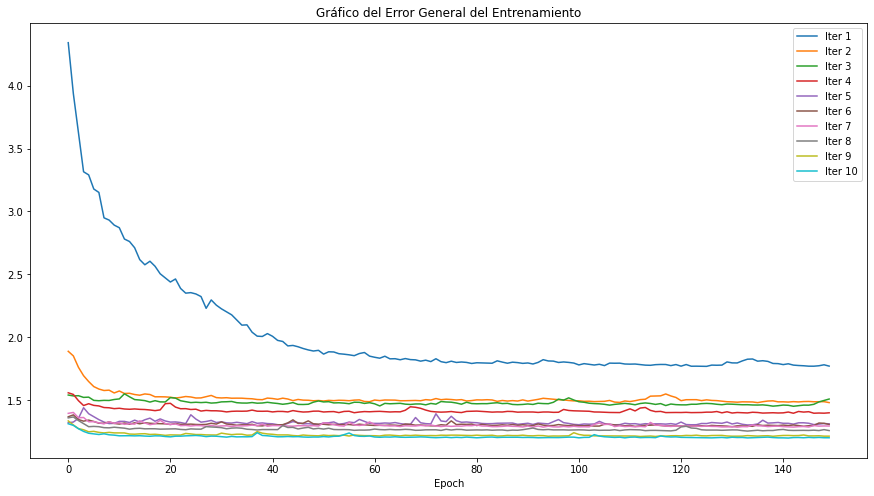

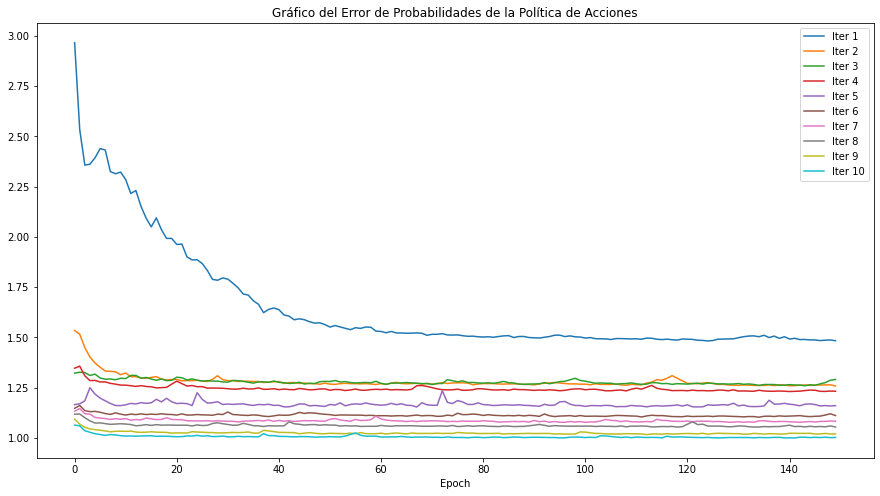

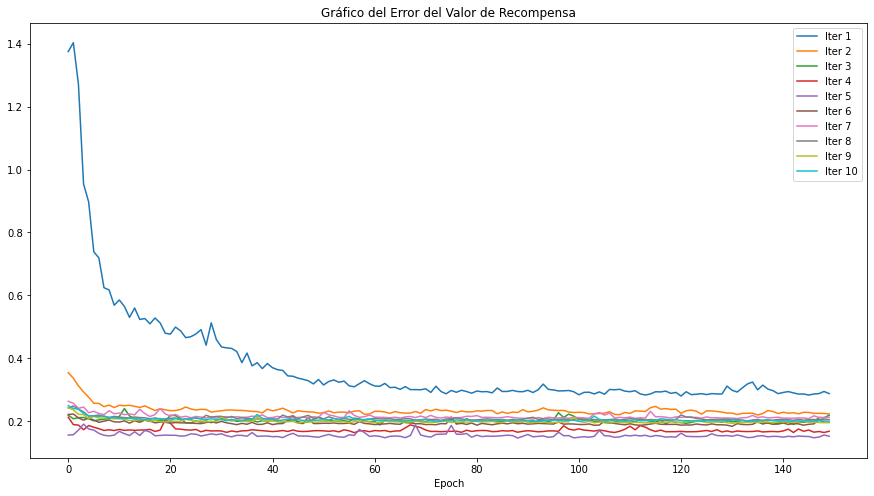

In [ ]:
#@title Mostrar Gráfico del Entrenamiento
if entrenar:
  nnet.genTrainGraphs("loss", "Gráfico del Error General del Entrenamiento")
  nnet.genTrainGraphs("pi_loss", "Gráfico del Error de Probabilidades de la Política de Acciones")
  nnet.genTrainGraphs("v_loss", "Gráfico del Error del Valor de Recompensa")
else:
  print("No se ha ejecutado el entrenamiento por lo que no ese puede mostrar el gráfico!")


In [ ]:
#@title Cargar o Guardar el Modelo de la RNA
# parámetros
directorio_modelo = '/content/gdrive/MyDrive/IA/demoRL/Modelos' #@param {type:"string"}
nombre_modelo_grabar = "AlphaZero-TaTeTi" #@param {type:"string"}
accion_realizar = "-" #@param ["-", "Cargar Modelo", "Grabar Modelo"]

if accion_realizar != "-":
  # Montar Drive
  from google.colab import drive
  drive.mount('/content/gdrive')
if accion_realizar == "Grabar Modelo":
  # guarda la politica del agente entrenado
  nnet.save_model(directorio_modelo, nombre_modelo_grabar)
elif accion_realizar == "Cargar Modelo":
  # carga la política del modelo
  nnet = NNetWrapper(juego, None)
  nnet.load_model(directorio_modelo, nombre_modelo_grabar)
  # define agente AlphaZero basado en la red cargada
  jugAZ = AlphaZeroPlayer(juego, nnet)  
  

Mounted at /content/gdrive


  Checkpoint grabado en '/content/gdrive/MyDrive/IA/demoRL/Modelos/AlphaZero-TaTeTi'


##Prueba

In [ ]:
#@title Probar el Agente Entrenado contra el Azar
cantidad_partidas_azar_probar = 100 #@param {type:"integer"}
mostrar_detalle_partidas_azar = False #@param {type:"boolean"}

# hacer jugar
print("\n> Probando el AlphaZero contra jugador al azar:")
ganaAZ, ganaRND, empateAZRND = Arena(jugAZ, jugRND, juego, display=ProblemGame.display, descJug1="AlphaZero", descJug2="Azar").playGames(cantidad_partidas_azar_probar, verbose=mostrar_detalle_partidas_azar)

# muestra resultados de todas las partidas
print("\n> Resultado Final: ")
print("   ", ganaAZ, " ganados por AlphaZero")
print("   ", ganaRND, " ganados por Azar")
print("   ", empateAZRND, " empatados")


> Probando el AlphaZero contra jugador al azar:


Arena.playGames (comienza AlphaZero):   0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-2-328dd03b9c50>:174: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return board.tostring()
Arena.playGames (comienza Azar): 100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


> Resultado Final: 
    94  ganados por AlphaZero
    0  ganados por Azar
    6  empatados


In [ ]:
#@title Probar el Agente Entrenado contra otro Agente Entrenado
cantidad_partidas_agentes_probar = 100 #@param {type:"integer"}
mostrar_detalle_partidas_agentes = False #@param {type:"boolean"}

# define agente AlphaZero 2 basado en la red entrenada
jugAZ2 = AlphaZeroPlayer(juego, nnet)

# hacer jugar
print("\n> Probando el AlphaZero contra otro AlphaZero:")
ganaAZ1, ganaAZ2, empateAZ = Arena(jugAZ, jugAZ2, juego, display=ProblemGame.display, descJug1="AlphaZero-1", descJug2="AlphaZero-2").playGames(cantidad_partidas_agentes_probar, verbose=mostrar_detalle_partidas_agentes)

# muestra resultados de todas las partidas
print("\n> Resultado Final: ")
print("   ", ganaAZ1, " ganados por AlphaZero-1")
print("   ", ganaAZ2, " ganados por AlphaZero-2")
print("   ", empateAZ, " empatados")


> Probando el AlphaZero contra otro AlphaZero:


Arena.playGames (comienza AlphaZero-1):   0%|          | 0/50 [00:00<?, ?it/s]<ipython-input-2-328dd03b9c50>:174: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return board.tostring()
Arena.playGames (comienza AlphaZero-2): 100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


> Resultado Final: 
    4  ganados por AlphaZero-1
    0  ganados por AlphaZero-2
    96  empatados


In [ ]:
#@title Probar el Agente Entrenado contra el Usuario (humano)

# hace jugar
print("\n> Probando el AlphaZero contra jugador humano:")
cont = True
while cont:
  Arena(jugAZ, jugHMN, juego, display=ProblemGame.display, descJug1="AlphaZero", descJug2="Usuario").playGame(verbose=True, ordenAzar=True)

  print("\n¿Desea jugar nuevamente? (S/N)")
  cont = (input().upper() == "S")



> Probando el AlphaZero contra jugador humano:
  1) comienza Usuario
Indique la coordenada donde desea jugar: 
11


<ipython-input-2-328dd03b9c50>:174: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return board.tostring()


         0 1 2 
        --------
      0 |- - - |
      1 |- O - |
      2 |- - - |
        --------
  2) le toca a AlphaZero
         0 1 2 
        --------
      0 |- - X |
      1 |- O - |
      2 |- - - |
        --------
  3) le toca a Usuario
Indique la coordenada donde desea jugar: 
2o
Coordenada inválida
Indique la coordenada donde desea jugar: 
20
         0 1 2 
        --------
      0 |- - X |
      1 |- O - |
      2 |O - - |
        --------
  4) le toca a AlphaZero
         0 1 2 
        --------
      0 |- - X |
      1 |- O - |
      2 |O - X |
        --------
  5) le toca a Usuario
Indique la coordenada donde desea jugar: 
12
         0 1 2 
        --------
      0 |- - X |
      1 |- O O |
      2 |O - X |
        --------
  6) le toca a AlphaZero
         0 1 2 
        --------
      0 |- - X |
      1 |X O O |
      2 |O - X |
        --------
  7) le toca a Usuario
Indique la coordenada donde desea jugar: 
00
         0 1 2 
        --------
      0 |O - X |
